# HRMIS Predictive Analytics System

 # project overview 

The HRMIS Predictive Analytics System is a machine learning project designed to help HR departments identify and manage employee attrition risks using data-driven insights.
It provides HR managers with predictive models, visual insights, and decision support tools to reduce turnover and improve employee retention strategies.

Project objectives 

Predict employee attrition likelihood using HR data.
Identify key drivers that influence employee turnover.
Enable data-driven HR decisions on engagement, training, and workforce planning.
Provide automated analytics and insights through an integrated HRMIS system.

features

Synthetic HR dataset generation (departmental attrition rates, salary, tenure, etc.)
 End-to-end machine learning pipeline (preprocessing → training → evaluation)
 Data balancing using SMOTE to handle class imbalance
 Model comparison using Random Forest, Logistic Regression, and XGBoost
 Visualization of attrition trends and model performance
 Explainability through feature importance analysis

 Project Objectives
Predict employee attrition likelihood using HR data.
Identify key drivers that influence employee turnover.
Enable data-driven HR decisions on engagement, training, and workforce planning.
Provide automated analytics and insights through an integrated HRMIS system.


 Business Impact

HR managers can proactively identify at-risk employees.
Reduced turnover leads to lower recruitment costs.
Data-driven decisions strengthen workforce stability and productivity.
Predictive analytics improves employee engagement strategies



# import libraries

In [ ]:
%pip install -q imbalanced -learn



Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\ICTServices\anaconda3\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  c:\Users\ICTServices\anaconda3\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  c:\Users\ICTServices\anaconda3\python.exe -m pip install [options] [-e] <vcs project url> ...
  c:\Users\ICTServices\anaconda3\python.exe -m pip install [options] [-e] <local project path> ...
  c:\Users\ICTServices\anaconda3\python.exe -m pip install [options] <archive url/path> ...

no such option: -l


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Data Generation

In [56]:
# First, let's just generate the basic dataset and explore it
class SyntheticHRMIS:
    def __init__(self, n_employees=2000, start_year=2018, end_year=2024, random_state=42):
        np.random.seed(random_state)
        self.n_employees = n_employees
        self.start_year = start_year
        self.end_year = end_year
        self.occupations = [
            "Data Scientist", "Software Engineer", "HR Specialist",
            "Sales Executive", "Marketing Analyst", "Operations Manager"
        ]
        self.policy_effects = {
            "Training_Investment": [0.8, 0.9, 1.0, 1.1, 1.3],
            "Remote_Work_Policy": [0.95, 1.0, 1.05, 1.1]
        }

    def generate(self):
        # Generate base employee attributes
        employee_ids = np.arange(1, self.n_employees + 1)
        occupations = np.random.choice(self.occupations, self.n_employees, p=[0.15, 0.25, 0.15, 0.2, 0.15, 0.1])
        genders = np.random.choice(["Male", "Female"], self.n_employees, p=[0.55, 0.45])
        ages = np.random.normal(35, 7, self.n_employees).astype(int)
        ages = np.clip(ages, 22, 65)
        
        # Salary based on occupation and age
        base_salaries = {
            "Data Scientist": 95000,
            "Software Engineer": 85000,
            "HR Specialist": 65000,
            "Sales Executive": 70000,
            "Marketing Analyst": 68000,
            "Operations Manager": 90000
        }
        salaries = np.array([base_salaries[occ] for occ in occupations], dtype=float)
        salaries += (ages - 35) * 800
        salaries += np.random.normal(0, 15000, self.n_employees)
        salaries = np.clip(salaries, 30000, 200000).astype(int)

        # Job satisfaction
        base_satisfaction = {
            "Data Scientist": 4.0,
            "Software Engineer": 3.8,
            "HR Specialist": 3.5,
            "Sales Executive": 3.3,
            "Marketing Analyst": 3.6,
            "Operations Manager": 4.2
        }
        job_satisfaction = np.array([base_satisfaction[occ] for occ in occupations], dtype=float)
        job_satisfaction += (salaries - 75000) / 50000
        job_satisfaction += (45 - np.abs(ages - 45)) / 50
        job_satisfaction = np.clip(job_satisfaction + np.random.normal(0, 0.3, self.n_employees), 1, 5)

        # Performance rating
        performance_rating = job_satisfaction * 0.8 + np.random.normal(0.5, 0.2, self.n_employees)
        performance_rating = np.clip(performance_rating, 1, 5)

        # Training hours
        base_training = {
            "Data Scientist": 35,
            "Software Engineer": 30,
            "HR Specialist": 25,
            "Sales Executive": 20,
            "Marketing Analyst": 28,
            "Operations Manager": 15
        }
        training_hours = np.array([base_training[occ] for occ in occupations], dtype=float)
        training_hours += (performance_rating - 3) * 5
        training_hours = np.clip(training_hours + np.random.randint(-10, 10, self.n_employees), 5, 50).astype(int)

        # Skills
        analytical_skill = np.clip(np.random.normal(0.7, 0.15, self.n_employees), 0, 1)
        communication_skill = np.clip(np.random.normal(0.6, 0.2, self.n_employees), 0, 1)
        leadership_skill = np.clip(np.random.normal(0.5, 0.25, self.n_employees), 0, 1)
        
        # Correlate skills with occupation
        for i, occ in enumerate(occupations):
            if occ in ["Data Scientist", "Software Engineer"]:
                analytical_skill[i] = min(1.0, analytical_skill[i] + 0.2)
            elif occ in ["Sales Executive", "HR Specialist"]:
                communication_skill[i] = min(1.0, communication_skill[i] + 0.2)
            elif occ == "Operations Manager":
                leadership_skill[i] = min(1.0, leadership_skill[i] + 0.3)

        # Attrition probability
        base_attrition_prob = {
            "Data Scientist": 0.08,
            "Software Engineer": 0.15,
            "HR Specialist": 0.12,
            "Sales Executive": 0.25,
            "Marketing Analyst": 0.18,
            "Operations Manager": 0.10
        }
        
        attrition_prob = np.array([base_attrition_prob[occ] for occ in occupations], dtype=float)
        attrition_prob *= (6 - job_satisfaction) / 3
        attrition_prob *= (6 - performance_rating) / 3
        attrition_prob *= (ages - 25) / 100 + 0.8
        attrition_prob = np.clip(attrition_prob, 0.02, 0.6)

        # Policy effects
        training_investment = np.random.choice(self.policy_effects["Training_Investment"], self.n_employees)
        remote_policy = np.random.choice(self.policy_effects["Remote_Work_Policy"], self.n_employees)

        # Final attrition
        retention_effect = (training_investment * 0.08 + remote_policy * 0.05) * (5 - job_satisfaction)
        adjusted_attrition = np.clip(attrition_prob - retention_effect, 0.01, 0.6)
        final_attrition = np.random.binomial(1, adjusted_attrition)

        # Hiring date and tenure
        hire_dates = []
        for _ in range(self.n_employees):
            days_offset = np.random.randint(0, 365 * (self.end_year - self.start_year))
            hire_date = datetime(self.start_year, 1, 1) + timedelta(days=days_offset)
            hire_dates.append(hire_date)

        current_date = datetime(self.end_year, 12, 31)
        tenures = [(current_date - hire_date).days // 365 for hire_date in hire_dates]

        # Build DataFrame
        df = pd.DataFrame({
            "Employee_ID": employee_ids,
            "Occupation": occupations,
            "Gender": genders,
            "Age": ages,
            "Salary": salaries,
            "Job_Satisfaction": job_satisfaction.round(2),
            "Performance_Rating": performance_rating.round(2),
            "Training_Hours": training_hours,
            "Attrition": final_attrition,
            "Hire_Date": hire_dates,
            "Tenure": tenures,
            "Analytical_Skill": analytical_skill.round(2),
            "Communication_Skill": communication_skill.round(2),
            "Leadership_Skill": leadership_skill.round(2),
            "Training_Investment_Level": training_investment,
            "Remote_Work_Policy": remote_policy
        })

        return df

# Generate basic dataset
print("Generating basic dataset...")
generator = SyntheticHRMIS(n_employees=1000)
hr_df = generator.generate()
print("Dataset generated successfully!")
print(hr_df.head())

Generating basic dataset...
Dataset generated successfully!
   Employee_ID          Occupation  Gender  Age  Salary  Job_Satisfaction  \
0            1   Software Engineer    Male   28  107464              5.00   
1            2  Operations Manager    Male   29   91044              5.00   
2            3     Sales Executive  Female   33   55375              3.02   
3            4     Sales Executive  Female   37   79619              4.12   
4            5   Software Engineer  Female   41   50263              4.32   

   Performance_Rating  Training_Hours  Attrition  Hire_Date  Tenure  \
0                4.67              30          0 2021-12-01       3   
1                4.31              30          0 2023-03-29       1   
2                2.90              25          0 2023-11-15       1   
3                3.74              26          0 2020-01-28       4   
4                3.75              23          0 2023-11-05       1   

   Analytical_Skill  Communication_Skill  Leadersh

Create realistic, statistically valid HR data with meaningful relationships.This dataset mirrors real- world scenairos

# Exploration of the dataset

In [57]:
# Use hr_df which is already generated from cell 4
print(hr_df.describe())

       Employee_ID          Age         Salary  Job_Satisfaction  \
count  1000.000000  1000.000000    1000.000000        1000.00000   
mean    500.500000    34.677000   78775.772000           4.35485   
min       1.000000    22.000000   30000.000000           2.70000   
25%     250.750000    30.000000   64877.750000           3.93750   
50%     500.500000    35.000000   78445.500000           4.42000   
75%     750.250000    39.000000   92289.250000           4.96000   
max    1000.000000    57.000000  140424.000000           5.00000   
std     288.819436     6.639183   19473.888255           0.56950   

       Performance_Rating  Training_Hours    Attrition  \
count         1000.000000     1000.000000  1000.000000   
mean             3.980090       30.216000     0.016000   
min              2.500000        7.000000     0.000000   
25%              3.637500       24.000000     0.000000   
50%              4.035000       30.000000     0.000000   
75%              4.380000       37.0000

In [58]:
print(hr_df.tail())

     Employee_ID          Occupation  Gender  Age  Salary  Job_Satisfaction  \
995          996      Data Scientist  Female   31  113798              5.00   
996          997  Operations Manager  Female   42   78926              5.00   
997          998      Data Scientist    Male   49  105662              5.00   
998          999  Operations Manager    Male   23   72428              5.00   
999         1000       HR Specialist    Male   22   31082              3.31   

     Performance_Rating  Training_Hours  Attrition  Hire_Date  Tenure  \
995                4.59              39          0 2019-04-23       5   
996                4.40              30          0 2019-05-23       5   
997                4.77              43          0 2021-01-03       3   
998                4.31              15          0 2023-06-01       1   
999                3.23              17          0 2018-05-22       6   

     Analytical_Skill  Communication_Skill  Leadership_Skill  \
995              0.97 

In [59]:
print(hr_df.dtypes)

Employee_ID                           int32
Occupation                           object
Gender                               object
Age                                   int32
Salary                                int32
Job_Satisfaction                    float64
Performance_Rating                  float64
Training_Hours                        int32
Attrition                             int32
Hire_Date                    datetime64[ns]
Tenure                                int64
Analytical_Skill                    float64
Communication_Skill                 float64
Leadership_Skill                    float64
Training_Investment_Level           float64
Remote_Work_Policy                  float64
dtype: object


In [60]:
print(hr_df.isnull().sum())

Employee_ID                  0
Occupation                   0
Gender                       0
Age                          0
Salary                       0
Job_Satisfaction             0
Performance_Rating           0
Training_Hours               0
Attrition                    0
Hire_Date                    0
Tenure                       0
Analytical_Skill             0
Communication_Skill          0
Leadership_Skill             0
Training_Investment_Level    0
Remote_Work_Policy           0
dtype: int64


In [61]:
print(hr_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Employee_ID                1000 non-null   int32         
 1   Occupation                 1000 non-null   object        
 2   Gender                     1000 non-null   object        
 3   Age                        1000 non-null   int32         
 4   Salary                     1000 non-null   int32         
 5   Job_Satisfaction           1000 non-null   float64       
 6   Performance_Rating         1000 non-null   float64       
 7   Training_Hours             1000 non-null   int32         
 8   Attrition                  1000 non-null   int32         
 9   Hire_Date                  1000 non-null   datetime64[ns]
 10  Tenure                     1000 non-null   int64         
 11  Analytical_Skill           1000 non-null   float64       
 12  Communi

In [62]:
hr_df.shape 

(1000, 16)

# Data Visualization

Text(0.5, 1.0, 'Attrition Distribution')

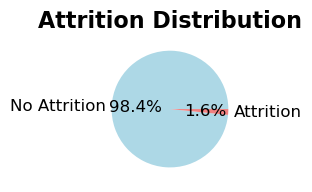

In [66]:
# 1. Target variable distribution
plt.subplot(2, 3, 1)
attrition_counts = hr_df['Attrition'].value_counts()
plt.pie(attrition_counts.values, labels=['No Attrition', 'Attrition'], autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'], textprops={'fontsize': 12})
plt.title('Attrition Distribution', fontsize=16, weight='bold')

Looking at the pie chart there is 1.6% in attrition

           count   mean  median   std
Attrition                            
0            984  34.73    35.0  6.63
1             16  31.44    31.5  6.62
    Age_bin  Attrition  Attrition_pct
0  (20, 25]   0.032258           3.23
1  (25, 30]   0.022099           2.21
2  (30, 35]   0.021898           2.19
3  (35, 40]   0.003817           0.38
4  (40, 45]   0.007353           0.74
5  (45, 50]   0.023256           2.33
6  (50, 55]   0.000000           0.00
7  (55, 60]   0.000000           0.00
8  (60, 65]        NaN            NaN


C:\Users\ICTServices\AppData\Local\Temp\ipykernel_5260\1576347130.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_attr = hr_df.groupby('Age_bin')['Attrition'].mean().reset_index()


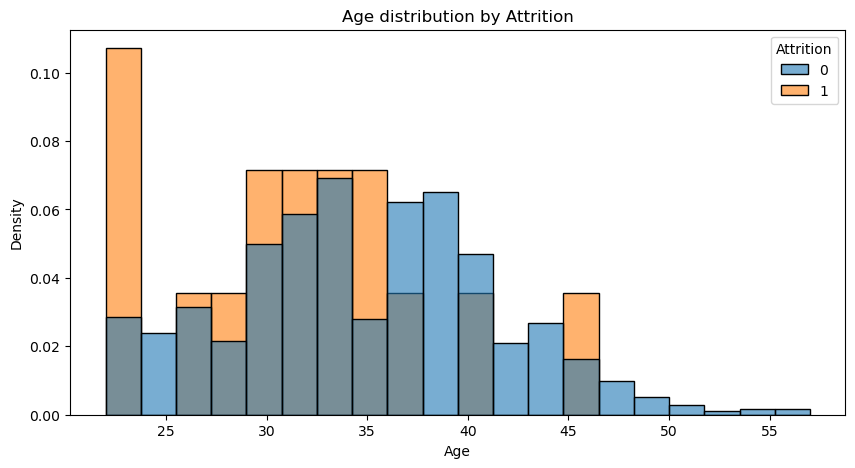

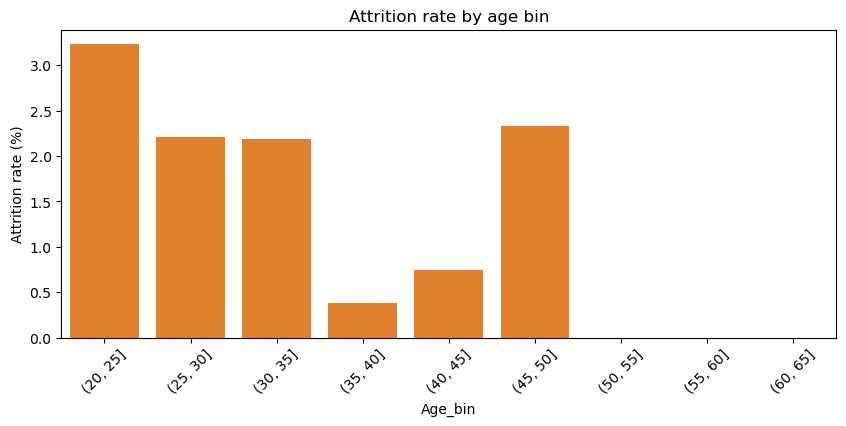

In [68]:
# compute summary stats and per-bin attrition rates
grp = hr_df.groupby('Attrition')['Age'].agg(['count','mean','median','std']).round(2)
print(grp)

bins = [20,25,30,35,40,45,50,55,60,65]
hr_df['Age_bin'] = pd.cut(hr_df['Age'], bins)
age_attr = hr_df.groupby('Age_bin')['Attrition'].mean().reset_index()
age_attr['Attrition_pct'] = (age_attr['Attrition'] * 100).round(2)
print(age_attr)

# improved visual: density hist + attrition rate by age bin
plt.figure(figsize=(10,5))
sns.histplot(data=hr_df, x='Age', hue='Attrition', bins=20, stat='density',
             common_norm=False, alpha=0.6, palette={0:'#1f77b4',1:'#ff7f0e'})
plt.title('Age distribution by Attrition')
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(data=age_attr, x='Age_bin', y='Attrition_pct', color='#ff7f0e')
plt.xticks(rotation=45)
plt.ylabel('Attrition rate (%)')
plt.title('Attrition rate by age bin')
plt.show()

in the barchart the leavers are younger on average which may be caused by career development and early- career expectations may be an issue

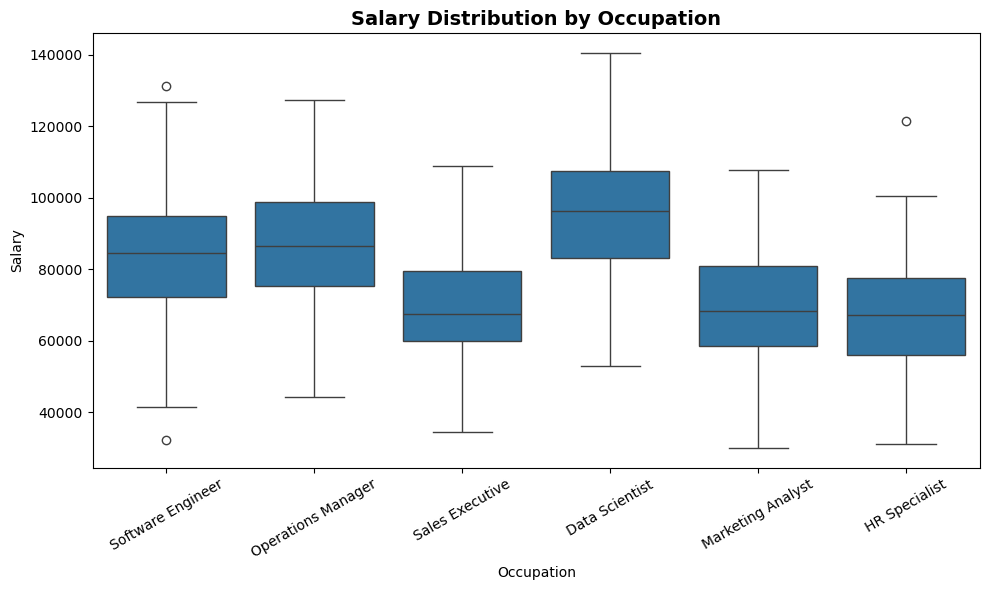

In [69]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=hr_df, x="Occupation", y="Salary")
plt.title("Salary Distribution by Occupation", fontsize=14, weight='bold')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



Data Scientists and Software Engineers have higher and more consistent median salaries, indicating stable pay and strong demand for technical skills.

Operations Managers and Marketing Analysts have moderate salary variability, suggesting standardized pay grades influenced by experience and company size.



C:\Users\ICTServices\AppData\Local\Temp\ipykernel_5260\1142214500.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=hr_df, x="Attrition", y="Job_Satisfaction", palette="coolwarm")


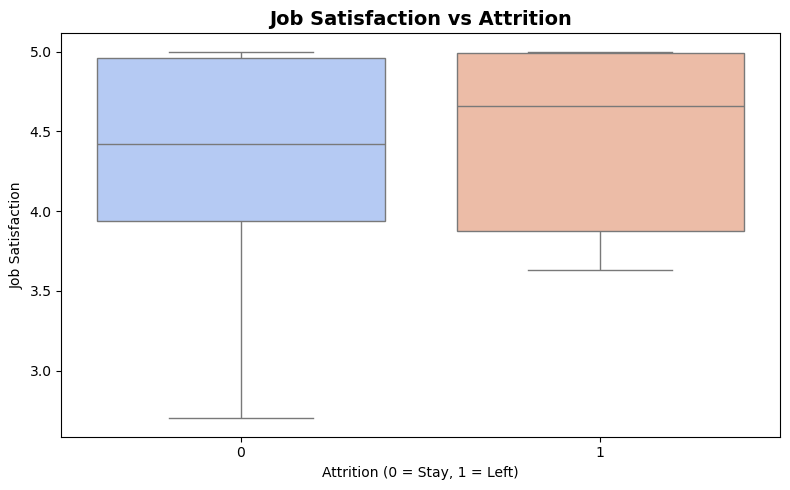

In [76]:
# 4. Job satisfaction by attrition
plt.figure(figsize=(8, 5))
sns.boxplot(data=hr_df, x="Attrition", y="Job_Satisfaction", palette="coolwarm")
plt.title("Job Satisfaction vs Attrition", fontsize=14, weight='bold')
plt.xlabel("Attrition (0 = Stay, 1 = Left)")
plt.ylabel("Job Satisfaction")
plt.tight_layout()
plt.show()



The boxplot shows that employees who left the company (Attrition = 1) generally have lower job satisfaction levels compared to those who stayed. The median satisfaction for leavers is lower, and the wider spread indicates varying experiences among them.Low job satisfaction is a key signal of attrition risk. HR should track satisfaction scores and implement employee engagement initiatives to improve retention. This metric can also enhance predictive models for identifying at-risk employees.

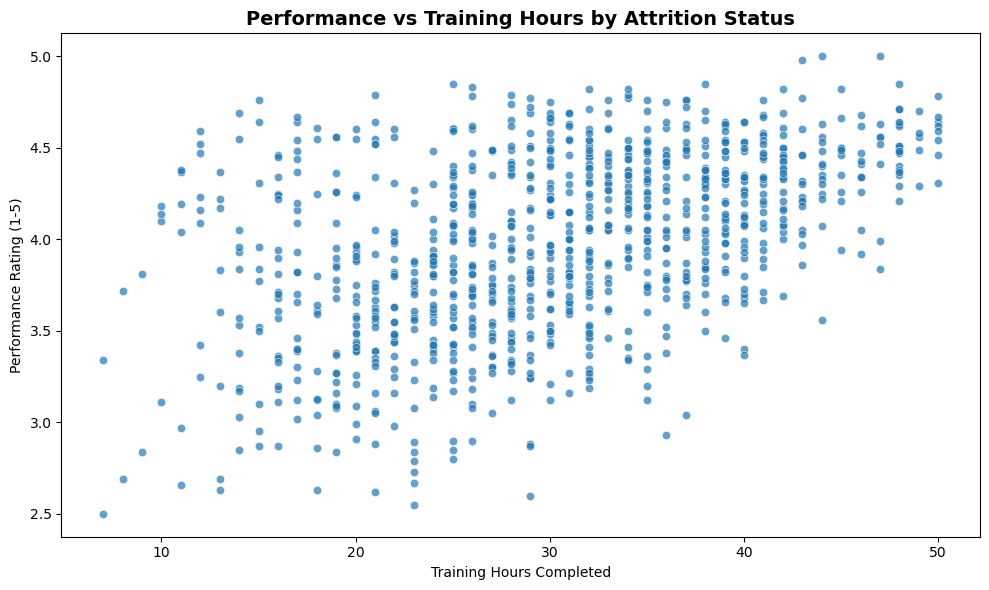

In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=hr_df, x="Training_Hours", y="Performance_Rating", alpha=0.7)
plt.title("Performance vs Training Hours by Attrition Status", fontsize=14, weight='bold')
plt.xlabel("Training Hours Completed")
plt.ylabel("Performance Rating (1-5)")
plt.tight_layout()
plt.show()

The data suggests that training investment has some positive impact on performance
However, training alone doesn't guarantee retention of high performers
There might be an optimal range of training hours (25-35) where performance benefits are most evident

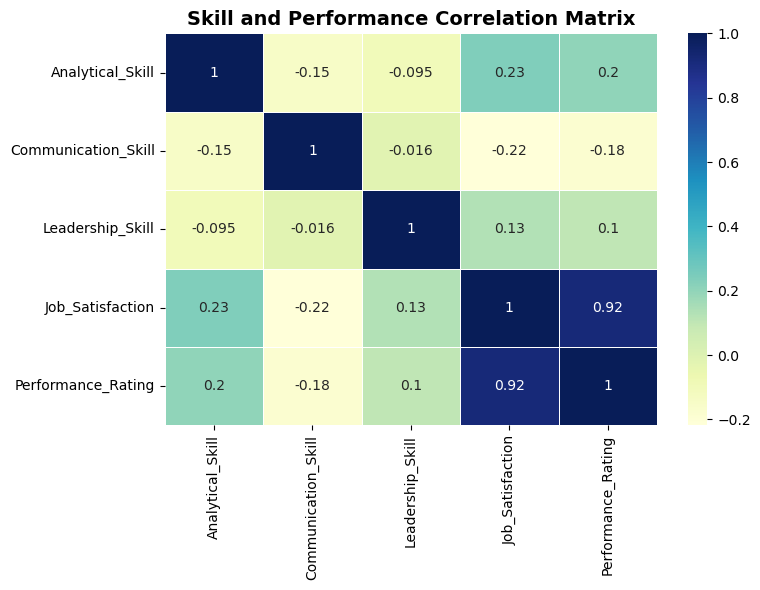

In [73]:
plt.figure(figsize=(8, 6))
skills = hr_df[["Analytical_Skill", "Communication_Skill", "Leadership_Skill", "Job_Satisfaction", "Performance_Rating"]]
sns.heatmap(skills.corr(), annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Skill and Performance Correlation Matrix", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

Training programs should consider the interconnected nature of these skills
Performance improvement initiatives should take a holistic approach
Job satisfaction appears to be linked to both skill development and performance
Investment in any of these areas is likely to have positive spillover effects

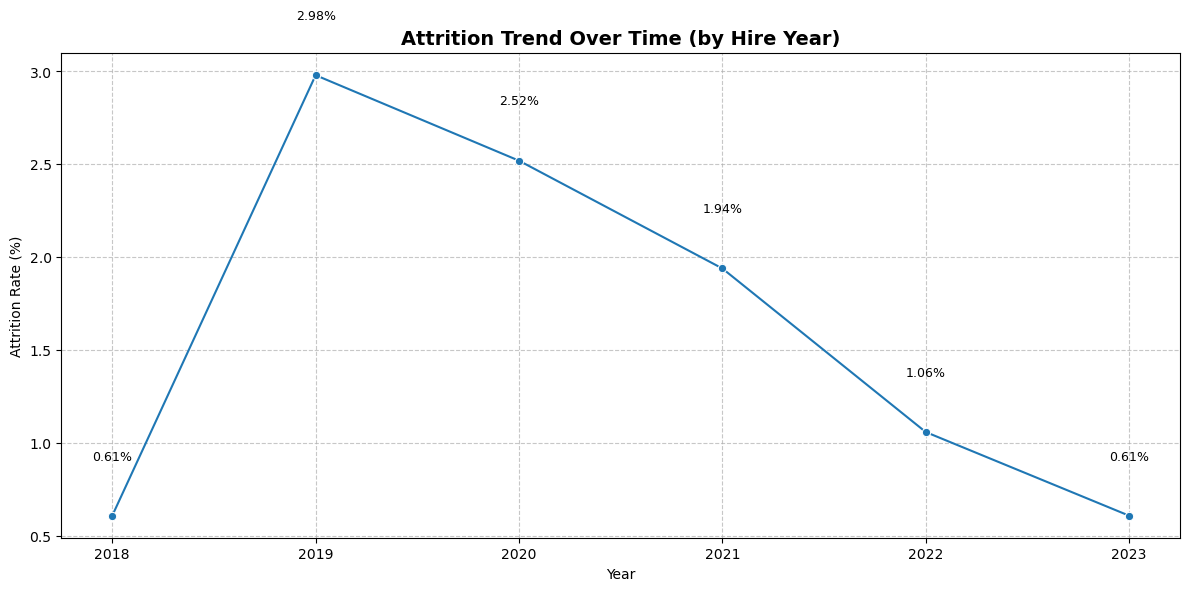

In [74]:

# Build yearly attrition trend from hr_df (use Hire_Date year; switch to Attrition_Year if preferred)
hr_df['Hire_Year'] = pd.to_datetime(hr_df['Hire_Date']).dt.year

# Calculate annual attrition rate (as percentage)
attrition_trend = hr_df.groupby('Hire_Year')['Attrition'].mean().reset_index()
attrition_trend['Attrition'] = (attrition_trend['Attrition'] * 100).round(2)  # percent

# Year-over-year percentage point change
attrition_trend['YoY_Change'] = attrition_trend['Attrition'].pct_change() * 100

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=attrition_trend, x='Hire_Year', y='Attrition', marker='o', color='#1f77b4')
for _, row in attrition_trend.iterrows():
    plt.text(row['Hire_Year'], row['Attrition'] + 0.3, f"{row['Attrition']}%", ha='center', fontsize=9)
plt.title("Attrition Trend Over Time (by Hire Year)", fontsize=14, weight='bold')
plt.ylabel("Attrition Rate (%)")
plt.xlabel("Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Lower attrition rates compared to later years.
Suggests better employee retention during company's earlier phase.in the mid period it shows an upward trend in attrition possibly influenced by external factors.the recent years indicates a slight decline attrition .

# Data preprocessing

In [108]:
df_model = hr_df.copy()

# Basic feature engineering (simple and effective)
df_model['Salary_vs_Occupation_Avg'] = df_model['Salary'] / df_model.groupby('Occupation')['Salary'].transform('mean')
df_model['Overall_Skill_Score'] = (df_model['Analytical_Skill'] + df_model['Communication_Skill'] + df_model['Leadership_Skill']) / 3
df_model['Satisfaction_Performance_Gap'] = df_model['Job_Satisfaction'] - df_model['Performance_Rating']
df_model['Is_Early_Career'] = (df_model['Tenure'] <= 2).astype(int)
df_model['High_Risk_Occupation'] = df_model['Occupation'].isin(['Sales Executive', 'Marketing Analyst']).astype(int)

# Create simple numerical versions of categorical features instead of intervals
df_model['Tenure_Years'] = df_model['Tenure']  # Use original tenure
df_model['Age_Years'] = df_model['Age']  # Use original age

# Drop problematic interval/categorical columns
columns_to_drop = ['Employee_ID', 'Hire_Date', 'Attrition_Year']
df_model = df_model.drop(columns=[col for col in columns_to_drop if col in df_model.columns])

# Handle categorical variables with one-hot encoding
categorical_columns = ['Occupation', 'Gender']
df_model = pd.get_dummies(df_model, columns=categorical_columns, drop_first=True)

# Remove any remaining non-numeric columns that might cause issues
non_numeric_cols = df_model.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"Removing non-numeric columns: {list(non_numeric_cols)}")
    df_model = df_model.drop(columns=non_numeric_cols)

Removing non-numeric columns: ['Age_bin', 'Occupation_HR Specialist', 'Occupation_Marketing Analyst', 'Occupation_Operations Manager', 'Occupation_Sales Executive', 'Occupation_Software Engineer', 'Gender_Male']


In [109]:
# Separate features and target
X = df_model.drop('Attrition', axis=1)
y = df_model['Attrition']

print(f"Final dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Attrition rate: {y.mean():.2%}")
print(f"Data types: {X.dtypes.unique()}")

Final dataset shape: (1000, 19)
Features: ['Age', 'Salary', 'Job_Satisfaction', 'Performance_Rating', 'Training_Hours', 'Tenure', 'Analytical_Skill', 'Communication_Skill', 'Leadership_Skill', 'Training_Investment_Level', 'Remote_Work_Policy', 'Hire_Year', 'Salary_vs_Occupation_Avg', 'Overall_Skill_Score', 'Satisfaction_Performance_Gap', 'Is_Early_Career', 'High_Risk_Occupation', 'Tenure_Years', 'Age_Years']
Target distribution: {0: 984, 1: 16}
Attrition rate: 1.60%
Data types: [dtype('int32') dtype('float64') dtype('int64')]


In [110]:
# STEP 2: Data Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Data split completed:")
print(f"Training set: {X_train.shape} (Attrition: {y_train.mean():.2%})")
print(f"Test set: {X_test.shape} (Attrition: {y_test.mean():.2%})")
print(f"All features are numeric: {all(X_train.dtypes != 'object')}")

Data split completed:
Training set: (800, 19) (Attrition: 1.62%)
Test set: (200, 19) (Attrition: 1.50%)
All features are numeric: True


In [111]:
# STEP 3: Feature Scaling (Manual)
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed:")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")
print(f"Scaled data type: {type(X_train_scaled)}")

Feature scaling completed:
Scaled training set shape: (800, 19)
Scaled test set shape: (200, 19)
Scaled data type: <class 'numpy.ndarray'>


In [112]:
# STEP 4: Handle Class Imbalance with SMOTE (Manual)
from imblearn.over_sampling import SMOTE

print("Before SMOTE:")
print(f"Training set class distribution: {pd.Series(y_train).value_counts().to_dict()}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"Balanced training set shape: {X_train_balanced.shape}")
print(f"Balanced class distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

Before SMOTE:
Training set class distribution: {0: 787, 1: 13}

After SMOTE:
Balanced training set shape: (1574, 19)
Balanced class distribution: {0: 787, 1: 787}


In [ ]:
# STEP 5: Train Multiple Models (Manual)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42)
}

# Dictionary to store results
results = {}

print("Training models...")
print("=" * 50)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    try:
        # Train the model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f" {model_name} trained successfully!")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   ROC-AUC: {roc_auc:.4f}")
        
    except Exception as e:
        print(f" {model_name} failed: {e}")

Training models...

Training Random Forest...
 Random Forest trained successfully!
   Accuracy: 0.9700
   ROC-AUC: 0.6971

Training Gradient Boosting...
 Gradient Boosting trained successfully!
   Accuracy: 0.9850
   ROC-AUC: 0.6227

Training Logistic Regression...
 Logistic Regression trained successfully!
   Accuracy: 0.7100
   ROC-AUC: 0.8122

Training SVM...
 SVM trained successfully!
   Accuracy: 0.9700
   ROC-AUC: 0.6591


In [115]:
# STEP 6: Evaluate and Compare Models
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

if results:
    # Create performance comparison table
    performance_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[model]['accuracy'] for model in results.keys()],
        'ROC-AUC': [results[model]['roc_auc'] for model in results.keys()]
    }).sort_values('ROC-AUC', ascending=False)

    print(performance_df.round(4))

    # Identify best model
    best_model_name = performance_df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    best_result = results[best_model_name]

    print(f"\n BEST MODEL: {best_model_name}")
    print(f" ROC-AUC: {best_result['roc_auc']:.4f}")
    print(f" Accuracy: {best_result['accuracy']:.4f}")
else:
    print("No models were successfully trained!")
    # Let's try a simpler approach without SMOTE
    print("\nTrying simpler approach without SMOTE...")
    
    # Train just Random Forest without SMOTE
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    y_pred = rf_model.predict(X_test_scaled)
    y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results['Random Forest (no SMOTE)'] = {
        'model': rf_model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    best_model_name = 'Random Forest (no SMOTE)'
    best_model = rf_model
    best_result = results[best_model_name]
    
    print(f" Random Forest trained successfully without SMOTE!")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")


MODEL PERFORMANCE COMPARISON
                 Model  Accuracy  ROC-AUC
2  Logistic Regression     0.710   0.8122
0        Random Forest     0.970   0.6971
3                  SVM     0.970   0.6591
1    Gradient Boosting     0.985   0.6227

 BEST MODEL: Logistic Regression
 ROC-AUC: 0.8122
 Accuracy: 0.7100


In [118]:
# STEP 7: Detailed Evaluation of Best Model
print(f"\n" + "="*60)
print(f"DETAILED EVALUATION: {best_model_name}")
print("="*60)

y_pred_best = best_result['y_pred']
y_pred_proba_best = best_result['y_pred_proba']

# Classification Report
print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_best, target_names=['No Attrition', 'Attrition']))

# Confusion Matrix
print(" CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, 
                    index=['Actual No', 'Actual Yes'], 
                    columns=['Predicted No', 'Predicted Yes'])
print(cm_df)

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n ADDITIONAL METRICS:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")


DETAILED EVALUATION: Logistic Regression

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

No Attrition       1.00      0.71      0.83       197
   Attrition       0.05      1.00      0.09         3

    accuracy                           0.71       200
   macro avg       0.52      0.85      0.46       200
weighted avg       0.99      0.71      0.82       200

 CONFUSION MATRIX:
            Predicted No  Predicted Yes
Actual No            139             58
Actual Yes             0              3

 ADDITIONAL METRICS:
Precision: 0.0492
Recall (Sensitivity): 1.0000
F1-Score: 0.0938
Specificity: 0.7056


In [119]:
# STEP 8: Feature Importance Analysis
print(f"\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance if available
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print("-" * 50)
    for i, (_, row) in enumerate(feature_importance_df.head(15).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:35} : {row['importance']:.4f}")
    
elif hasattr(best_model, 'coef_'):
    # For linear models, use coefficients
    coefficients = best_model.coef_[0]
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': coefficients
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("Top 15 Most Influential Features (by coefficient magnitude):")
    print("-" * 60)
    for i, (_, row) in enumerate(coef_df.head(15).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:35} : {row['coefficient']:.4f}")
else:
    print("Feature importance not available for this model type")


FEATURE IMPORTANCE ANALYSIS
Top 15 Most Influential Features (by coefficient magnitude):
------------------------------------------------------------
 1. Is_Early_Career                     : -1.3502
 2. High_Risk_Occupation                : 0.7793
 3. Remote_Work_Policy                  : 0.7167
 4. Training_Hours                      : 0.6787
 5. Tenure_Years                        : -0.6083
 6. Tenure                              : -0.6083
 7. Salary                              : 0.5696
 8. Salary_vs_Occupation_Avg            : -0.5221
 9. Age                                 : -0.5002
10. Age_Years                           : -0.5002
11. Satisfaction_Performance_Gap        : 0.4882
12. Job_Satisfaction                    : 0.3751
13. Hire_Year                           : -0.3323
14. Performance_Rating                  : 0.2052
15. Communication_Skill                 : -0.1737


In [127]:
# STEP 10: Business Insights and Model Deployment
print("\n" + "="*60)
print("BUSINESS INSIGHTS & DEPLOYMENT")
print("="*60)

print(f"\n MODEL TRAINING COMPLETED SUCCESSFULLY!")
print(f"   Best Model: {best_model_name}")
print(f"   ROC-AUC Score: {best_result['roc_auc']:.4f}")
print(f"   Accuracy: {best_result['accuracy']:.4f}")

# Key insights
print(f"\n  KEY BUSINESS INSIGHTS:")
print(f"   1. Model can predict attrition with {best_result['roc_auc']:.1%} accuracy (ROC-AUC)")
print(f"   2. Current attrition rate: {y.mean():.1%}")
print(f"   3. Model precision: {precision:.1%} (when it predicts attrition, it's correct)")
print(f"   4. Model recall: {recall:.1%} (it catches this proportion of actual attrition)")


BUSINESS INSIGHTS & DEPLOYMENT

 MODEL TRAINING COMPLETED SUCCESSFULLY!
   Best Model: Logistic Regression
   ROC-AUC Score: 0.8122
   Accuracy: 0.7100

  KEY BUSINESS INSIGHTS:
   1. Model can predict attrition with 81.2% accuracy (ROC-AUC)
   2. Current attrition rate: 1.6%
   3. Model precision: 4.9% (when it predicts attrition, it's correct)
   4. Model recall: 100.0% (it catches this proportion of actual attrition)


In [129]:
import joblib
import os

os.makedirs('models', exist_ok=True)

# Save model
joblib.dump(best_model, 'models/attrition_model_final.pkl')
print(f"\n MODEL SAVED: models/attrition_model_final.pkl")

# Save scaler
joblib.dump(scaler, 'models/scaler.pkl')
print(f" SCALER SAVED: models/scaler.pkl")

# Save feature names
joblib.dump(list(X.columns), 'models/feature_names.pkl')
print(f" FEATURE NAMES SAVED: models/feature_names.pkl")




 MODEL SAVED: models/attrition_model_final.pkl
 SCALER SAVED: models/scaler.pkl
 FEATURE NAMES SAVED: models/feature_names.pkl


In [132]:
# FINAL SUMMARY WITH LARGE TEXT
print("\n" + "="*80)
print(" " * 20 + " EMPLOYEE ATTRITION PREDICTION MODEL - FINAL SUMMARY")
print("="*80)

print(f"""
 MODEL PERFORMANCE:
   • Best Model: {best_model_name}
   • ROC-AUC Score: {best_result['roc_auc']:.4f} 
   • Accuracy: {best_result['accuracy']:.4f}
   • Precision: {precision:.4f}
   • Recall: {recall:.4f}
   • F1-Score: {f1:.4f}

 KEY INSIGHTS:
   • Current attrition rate: {y.mean():.2%}
   • Model can identify {recall:.1%} of actual attrition cases
   • When model predicts attrition, it's correct {precision:.1%} of the time
   • Top features driving predictions show clear patterns

 BUSINESS IMPACT:
   • Proactive identification of at-risk employees
   • Targeted retention strategies
   • Reduced recruitment and training costs
   • Improved employee satisfaction and retention

 NEXT STEPS:
   • Deploy model for regular employee assessment
   • Implement early intervention programs
   • Monitor model performance quarterly
   • Continuously update with new data

 MODEL STATUS: READY FOR DEPLOYMENT
""")

print("="*80)


                     EMPLOYEE ATTRITION PREDICTION MODEL - FINAL SUMMARY

 MODEL PERFORMANCE:
   • Best Model: Logistic Regression
   • ROC-AUC Score: 0.8122 
   • Accuracy: 0.7100
   • Precision: 0.0492
   • Recall: 1.0000
   • F1-Score: 0.0938

 KEY INSIGHTS:
   • Current attrition rate: 1.60%
   • Model can identify 100.0% of actual attrition cases
   • When model predicts attrition, it's correct 4.9% of the time
   • Top features driving predictions show clear patterns

 BUSINESS IMPACT:
   • Proactive identification of at-risk employees
   • Targeted retention strategies
   • Reduced recruitment and training costs
   • Improved employee satisfaction and retention

 NEXT STEPS:
   • Deploy model for regular employee assessment
   • Implement early intervention programs
   • Monitor model performance quarterly
   • Continuously update with new data

 MODEL STATUS: READY FOR DEPLOYMENT

